# Human Activity Recognition - Baselines

Last Update : 21 July 2019

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/conv


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import h5py


import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset

In [4]:
from utils.data.tsdata import get_timeseries_dataset

from skssl.transformers.neuralproc.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.1, max_n_indcs=0.5),
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt_feat = CntxtTrgtGetter(contexts_getter=get_all_indcs,
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes


get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.5, max_n_indcs=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False):
    def mycollate(batch):
        min_length = min([v.size(0) for b in batch for k,v in b[0].items() if "X" in k])
        # chose first min_legth of each (assumes that randomized)
        
        batch = [({k:v[:min_length, ...] for k,v in b[0].items()}, b[1]) for b in batch]        
        collated = torch.utils.data.dataloader.default_collate(batch)
        
        X = collated[0]["X"]
        y = collated[0]["y"]
        
        if is_repeat_batch:
            
            X = torch.cat([X,X], dim=0)
            y = torch.cat([y,y], dim=0)
        
        collated[0]["X"], collated[0]["y"], collated[0]["X_trgt"], collated[0]["y_trgt"] = get_cntxt_trgt(X, y)
        
        return collated
    return mycollate


data_train = get_timeseries_dataset("har")(split="train", is_fill_mean=True, data_perc=1)
data_test = get_timeseries_dataset("har")(split="test", is_fill_mean=True, data_perc=1)

In [5]:
np.unique(data_test.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([496, 471, 420, 491, 532, 537]))

In [6]:
# best acc
537 / len(data_test.targets)

0.18221920597217509

In [7]:
X_DIM = 1  # 1D spatial input (although actually 2 but the first is for sparse channels)
Y_DIM = data_train.data.shape[-1] # multiple channels
N_TARGETS = len(np.unique(data_train.targets))

sampling_percentages = [0.05, 0.1, 0.3, 0.5, 0.7, 1]
label_percentages = [N_TARGETS, N_TARGETS*2, 0.01, 0.05, 0.1, 0.3, 0.5]

## Model

In [8]:
import torch.nn as nn
from skssl.predefined import RNN, MLP
from utils.helpers import count_parameters

In [9]:
class FeatureMLP(nn.Module):

    def __init__(self, input_size, output_size, **kwargs):
        super().__init__()
        self.out = MLP(input_size*4, output_size, **kwargs)

    def forward(self, X, y=None):

        if y is not None:
            # is there's y then that's the actual input and X is time
            X = y

        outputs = self.out(torch.cat([X.mean(-2), X.max(-2)[0], X.min(-2)[0], X.var(-2)], dim=-1))
        return outputs

In [10]:
models = {}

models["bi_rnn_delta"] = partial(RNN, input_size=Y_DIM, hidden_size=64, output_size=N_TARGETS, bidirectional=True, n_layers=1, dropout=0.5, is_add_delta=True)
models["feature_mlp"]  = partial(FeatureMLP, input_size=Y_DIM, output_size=N_TARGETS, hidden_size=128, dropout=0.5, n_hidden_layers=3, is_res=True)

In [11]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

bi_rnn_delta - N Param: 29574
feature_mlp - N Param: 38534


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


- selected best rnn from [GRU, LSTM], hidden [32,64,128], [bidirect,None], dropout [0,0.5], lr [1e-4,1e-3], layer [1,2]
- selected best feature MLP from hidden [32,64,128], n_hidden_layers [1,3], dropout [0,0.5], [is_res, None], lr [1e-4,1e-3]

all with early stoping patience 10, cross entropy, standardized data, 100 epochs, batch size 64

# Sub Labels Training

In [12]:
from utils.data.ssldata import get_train_dev_test_ssl
from skssl.training.loaders import get_supervised_iterator
from ntbks_helpers import train_models_

In [13]:
N_EPOCHS = 100 
BATCH_SIZE = 64
IS_RETRAIN = False # if false load precomputed
chckpnt_dirname="results/challenge/har/"

In [14]:
data_trainers = {}
samplig_perc = 0.5

for label_perc in label_percentages:
    data_train, _, data_test = get_train_dev_test_ssl("har", n_labels=label_perc, data_perc=samplig_perc, dev_size=0)
    
    data_trainers.update(train_models_({"{}%har_{}%lab".format(int(samplig_perc*100), int(label_perc*100)): (data_train, data_test)}, 
                         models, 
                         chckpnt_dirname=chckpnt_dirname,
                          max_epochs=N_EPOCHS,
                          batch_size=64,
                         is_retrain=IS_RETRAIN, 
                         iterator_train=get_supervised_iterator))


--- Loading 50%har_600%lab/bi_rnn_delta ---

50%har_600%lab/bi_rnn_delta best epoch: 25 val_loss: 1.7031053005738868

--- Loading 50%har_600%lab/feature_mlp ---

50%har_600%lab/feature_mlp best epoch: 100 val_loss: 1.2070192208644452


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



--- Loading 50%har_1200%lab/bi_rnn_delta ---

50%har_1200%lab/bi_rnn_delta best epoch: 34 val_loss: 1.468012556610651

--- Loading 50%har_1200%lab/feature_mlp ---

50%har_1200%lab/feature_mlp best epoch: 100 val_loss: 0.9724344174094147


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



--- Loading 50%har_1%lab/bi_rnn_delta ---

50%har_1%lab/bi_rnn_delta best epoch: 68 val_loss: 1.1848216887688612

--- Loading 50%har_1%lab/feature_mlp ---

50%har_1%lab/feature_mlp best epoch: 90 val_loss: 0.6480910628376713


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



--- Loading 50%har_5%lab/bi_rnn_delta ---

50%har_5%lab/bi_rnn_delta best epoch: 37 val_loss: 0.5261391364480424

--- Loading 50%har_5%lab/feature_mlp ---

50%har_5%lab/feature_mlp best epoch: 34 val_loss: 0.6083724190511661


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



--- Loading 50%har_10%lab/bi_rnn_delta ---

50%har_10%lab/bi_rnn_delta best epoch: 52 val_loss: 0.29275474525687245

--- Loading 50%har_10%lab/feature_mlp ---

50%har_10%lab/feature_mlp best epoch: 43 val_loss: 0.4748540673775312


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



--- Loading 50%har_30%lab/bi_rnn_delta ---

50%har_30%lab/bi_rnn_delta best epoch: 16 val_loss: 0.242327061919467

--- Loading 50%har_30%lab/feature_mlp ---

50%har_30%lab/feature_mlp best epoch: 43 val_loss: 0.38917470055189546


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



--- Loading 50%har_50%lab/bi_rnn_delta ---

50%har_50%lab/bi_rnn_delta best epoch: 30 val_loss: 0.22852476952963455

--- Loading 50%har_50%lab/feature_mlp ---

50%har_50%lab/feature_mlp best epoch: 39 val_loss: 0.3619322175691603


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [15]:
for k,t in data_trainers.items():
    if "bi_rnn_delta"not in k:
        continue
    print()
        
    for e, h in enumerate(t.history[::-1]):
        if h["valid_loss_best"]:
            print(k, "epoch:", len(t.history)-e, 
                  "val_loss:", h["valid_loss"], 
                  "val_acc:", h["valid_acc"])
            break


50%har_600%lab/bi_rnn_delta epoch: 25 val_loss: 1.7031053005738868 val_acc: 0.28944689514760774

50%har_1200%lab/bi_rnn_delta epoch: 34 val_loss: 1.468012556610651 val_acc: 0.4896504920257889

50%har_1%lab/bi_rnn_delta epoch: 68 val_loss: 1.1848216887688612 val_acc: 0.6335256192738378

50%har_5%lab/bi_rnn_delta epoch: 37 val_loss: 0.5261391364480424 val_acc: 0.839837122497455

50%har_10%lab/bi_rnn_delta epoch: 52 val_loss: 0.29275474525687245 val_acc: 0.8985408890397014

50%har_30%lab/bi_rnn_delta epoch: 16 val_loss: 0.242327061919467 val_acc: 0.9070240922972514

50%har_50%lab/bi_rnn_delta epoch: 30 val_loss: 0.22852476952963455 val_acc: 0.9124533423820834


# SSL EVAL

In [16]:
from skssl.classifiers import LabelSpreading
from joblib import dump, load

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:

samplig_perc = 0.5

for label_perc in label_percentages:
    data_train, _, data_test = get_train_dev_test_ssl("har", n_labels=label_perc, data_perc=samplig_perc, dev_size=0)
    file = chckpnt_dirname+"{}%har_{}%lab/feature_labelspread.joblib".format(int(samplig_perc*100), int(label_perc*100))
    
    X_test = np.concatenate([data_test.data.mean(1), data_test.data.min(1), data_test.data.max(1), 
                                  data_test.data.std(1)], axis=-1)
    
    if True:
        X_train = np.concatenate([data_train.data.mean(1), data_train.data.min(1), data_train.data.max(1), 
                                  data_train.data.std(1)], axis=-1)
        Y_train = data_train.targets.flatten()
        Y_test_unsup = -1*np.ones_like(data_test.targets.flatten())
        
        
        clf = LabelSpreading(kernel="rbf", gamma=0.7139, n_jobs=-1, max_iter=50, alpha=0.35)
        clf.fit(np.concatenate([X_train, X_test], axis=0),  
                np.concatenate([Y_train, Y_test_unsup], axis=0))
        #clf.fit(X_train,  Y_train)
        dump(clf, file) 
        
    else:
        
        clf = load(file)
        
    
    
    print("Label Spreading on {}% of data".format(label_perc*100), 
          clf.score(X_test, data_test.targets.flatten()))

Label Spreading on 600% of data 0.6104513064133017
Label Spreading on 1200% of data 0.5778758059043094
Label Spreading on 1.0% of data 0.7020699015948422
Label Spreading on 5.0% of data 0.7387173396674585
Label Spreading on 10.0% of data 0.7645062775704106
Label Spreading on 30.0% of data 0.7852052935188327
Label Spreading on 50.0% of data 0.7882592466915507


# CNP

In [18]:
import torch.nn as nn
from skssl.transformers import GlobalNeuralProcess, NeuralProcessLoss, AttentiveNeuralProcess
from skssl.utils.helpers import rescale_range
from skssl.predefined import UnetCNN, CNN, MLP, SparseSetConv, SetConv, MlpRBF, GaussianRBF, BatchSparseSetConv
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split
from utils.helpers import count_parameters

In [19]:
from copy import deepcopy

models = {}

unet = partial(UnetCNN,
               Conv=torch.nn.Conv1d,
               Pool=torch.nn.MaxPool1d,
               upsample_mode="linear",
               n_layers=18,
               is_double_conv=True,
               is_depth_separable=True,
               Normalization=torch.nn.BatchNorm1d,
               is_chan_last=True,
               bottleneck=None,
               kernel_size=7,
               max_nchannels=256,
              is_force_same_bottleneck=True
              )

kwargs = dict(x_dim=X_DIM, 
              y_dim=Y_DIM,
              min_std=5e-3,
                n_tmp_queries=128,
                r_dim=64,
              keys_to_tmp_attn=partial(SetConv, RadialBasisFunc=GaussianRBF),
              TmpSelfAttn=unet,
              tmp_to_queries_attn=partial(SetConv, RadialBasisFunc=GaussianRBF),
              is_skip_tmp=False,
              is_use_x=False,
              get_cntxt_trgt=precomputed_cntxt_trgt_split,
              is_encode_xy=False)

models["transformer_gnp_large_shared_bottleneck"] = partial(GlobalNeuralProcess, **kwargs)


In [20]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

transformer_gnp_large_shared_bottleneck - N Param: 1006936


In [21]:
from ntbks_helpers import train_models_
from skorch.dataset import CVSplit

In [22]:
data_trainers_feat = {}
datas = {p:get_timeseries_dataset("har")(split="both", data_perc=p, is_fill_mean=False)
         for p in sampling_percentages}

for p,data in datas.items():
    data_trainers_feat.update(train_models_({"{}%har".format(int(p*100)): data}, 
                              models, 
                              NeuralProcessLoss,
                             patience=15,
                              chckpnt_dirname=chckpnt_dirname,
                              max_epochs=N_EPOCHS,
                              batch_size=BATCH_SIZE,
                              is_retrain=IS_RETRAIN,
                              callbacks=[],
                              train_split=CVSplit(0.05),
                              iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=True),  
                              iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_test),
                              mode="transformer"))


--- Loading 5%har/transformer_gnp_large_shared_bottleneck ---

5%har/transformer_gnp_large_shared_bottleneck best epoch: 98 val_loss: -2.164531707763672

--- Loading 10%har/transformer_gnp_large_shared_bottleneck ---

10%har/transformer_gnp_large_shared_bottleneck best epoch: 86 val_loss: -2.98053588682008

--- Loading 30%har/transformer_gnp_large_shared_bottleneck ---

30%har/transformer_gnp_large_shared_bottleneck best epoch: 87 val_loss: -4.5797279249117215

--- Loading 50%har/transformer_gnp_large_shared_bottleneck ---

50%har/transformer_gnp_large_shared_bottleneck best epoch: 72 val_loss: -5.531349883959131

--- Loading 70%har/transformer_gnp_large_shared_bottleneck ---

70%har/transformer_gnp_large_shared_bottleneck best epoch: 98 val_loss: -7.103462460897501

--- Loading 100%har/transformer_gnp_large_shared_bottleneck ---

100%har/transformer_gnp_large_shared_bottleneck best epoch: 86 val_loss: -8.16725208180622


# No Joint

In [23]:
from utils.data.helpers import make_ssl_dataset_
from utils.data.ssldata import get_train_dev_test_ssl
from skssl.training.loaders import get_supervised_iterator
from skorch.dataset import Dataset

In [24]:
data_trainers.keys()

dict_keys(['50%har_600%lab/bi_rnn_delta', '50%har_600%lab/feature_mlp', '50%har_1200%lab/bi_rnn_delta', '50%har_1200%lab/feature_mlp', '50%har_1%lab/bi_rnn_delta', '50%har_1%lab/feature_mlp', '50%har_5%lab/bi_rnn_delta', '50%har_5%lab/feature_mlp', '50%har_10%lab/bi_rnn_delta', '50%har_10%lab/feature_mlp', '50%har_30%lab/bi_rnn_delta', '50%har_30%lab/feature_mlp', '50%har_50%lab/bi_rnn_delta', '50%har_50%lab/feature_mlp'])

In [25]:
class FeatureMLP(nn.Module):

    def __init__(self, feat_size, y_dim, output_size, **kwargs):
        super().__init__()
        self.out = MLP(feat_size+y_dim*4, output_size, **kwargs)

    def forward(self, X, X_feat, y=None):

        if y is not None:
            # is there's y then that's the actual input and X is time
            X = y

        outputs = self.out(torch.cat([X_feat, X.mean(-2), X.max(-2)[0], X.min(-2)[0], X.var(-2)], dim=-1))
        return outputs

In [26]:
models = dict(mlp_hand = partial(FeatureMLP, feat_size=256, y_dim=Y_DIM, output_size=N_TARGETS, hidden_size=128, 
                dropout=0.5, n_hidden_layers=3, is_res=True))

In [27]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

mlp_hand - N Param: 71302


In [28]:
for k, trainer in data_trainers_feat.items():
    if "50%" not in k: #and "100%" not in k:
        continue # only 100%  and 50% for now
    
    for label_perc in label_percentages:
        samplig_perc = float(k.split("%")[0]) / 100
        n_train = datas[samplig_perc].n_train
        model_name = k.split("/")[1]
        data_train, _, data_test = get_train_dev_test_ssl("har", n_labels=label_perc, 
                                                          data_perc=samplig_perc, 
                                                          dev_size=0,
                                                          transformed_file=chckpnt_dirname+k+"/transformed_data.npy")

        X_train, X_test, Y_train, Y_test = data_train.data, data_test.data, data_train.targets.squeeze(), data_test.targets.squeeze()

        data_trainers.update(train_models_({"{}%har_{}%lab".format(int(samplig_perc*100), int(label_perc*100)): (Dataset(X={"X_feat":X_train.astype(np.float32), 
                                                                       "X":datas[samplig_perc].data[:n_train].astype(np.float32)}, 
                                                                    y=torch.from_numpy(Y_train).long()), 
                                                            Dataset(X={"X_feat":X_test.astype(np.float32), 
                                                                       "X":datas[samplig_perc].data[n_train:].astype(np.float32)}, 
                                                                    y=torch.from_numpy(Y_test).long()))}, 
                                                   {model_name +"/feat_"+ name: partial(m, feat_size=X_train.shape[-1]) for name,m in models.items()}, 
                                                     chckpnt_dirname=chckpnt_dirname,
                                                      max_epochs=N_EPOCHS,
                                                      batch_size=BATCH_SIZE,
                                                     is_retrain=IS_RETRAIN,
                                                   iterator_train=get_supervised_iterator,
                                                     callbacks=[]))



--- Loading 50%har_600%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

50%har_600%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 100 val_loss: 0.8602534753915452

--- Loading 50%har_1200%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

50%har_1200%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 100 val_loss: 0.5534121561624821

--- Loading 50%har_1%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

50%har_1%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 67 val_loss: 0.3021506258328567

--- Loading 50%har_5%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

50%har_5%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 16 val_loss: 0.2518727869189793

--- Loading 50%har_10%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand ---

50%har_10%lab/transformer_gnp_large_shared_bottleneck/feat_mlp_hand best epoch: 18 val_loss: 0.1770280350011438

--- L

In [29]:
for k,t in data_trainers.items():
    for e, h in enumerate(t.history[::-1]):
        if h["valid_loss_best"]:
            print(k, "epoch:", len(t.history)-e, 
                  "val_loss:", h["valid_loss"], 
                  "val_acc:", h["valid_acc"])
            break

50%har_600%lab/bi_rnn_delta epoch: 25 val_loss: 1.7031053005738868 val_acc: 0.28944689514760774
50%har_600%lab/feature_mlp epoch: 100 val_loss: 1.2070192208644452 val_acc: 0.5727858839497795
50%har_1200%lab/bi_rnn_delta epoch: 34 val_loss: 1.468012556610651 val_acc: 0.4896504920257889
50%har_1200%lab/feature_mlp epoch: 100 val_loss: 0.9724344174094147 val_acc: 0.6369189005768578
50%har_1%lab/bi_rnn_delta epoch: 68 val_loss: 1.1848216887688612 val_acc: 0.6335256192738378
50%har_1%lab/feature_mlp epoch: 90 val_loss: 0.6480910628376713 val_acc: 0.7475398710553105
50%har_5%lab/bi_rnn_delta epoch: 37 val_loss: 0.5261391364480424 val_acc: 0.839837122497455
50%har_5%lab/feature_mlp epoch: 34 val_loss: 0.6083724190511661 val_acc: 0.7553444180522565
50%har_10%lab/bi_rnn_delta epoch: 52 val_loss: 0.29275474525687245 val_acc: 0.8985408890397014
50%har_10%lab/feature_mlp epoch: 43 val_loss: 0.4748540673775312 val_acc: 0.8177807940278249
50%har_30%lab/bi_rnn_delta epoch: 16 val_loss: 0.242327061919

## SSL Evaluation

In [30]:
from skssl.classifiers import LabelSpreading
from joblib import dump, load
from skssl.meta import SelfTrainingMeta
from sklearn.neural_network import MLPClassifier


In [31]:
for k, trainer in data_trainers_feat.items():
    if "50%" not in k: #and "100%" not in k:
        continue # only 100%  and 50% for now
        
    for label_perc in label_percentages:
        samplig_perc = float(k.split("%")[0]) / 100
        n_train = datas[samplig_perc].n_train
        model_name = k.split("/")[1]
        
        data_train, _, data_test = get_train_dev_test_ssl("har", n_labels=label_perc, 
                                                              data_perc=samplig_perc, 
                                                              dev_size=0,
                                                              transformed_file=chckpnt_dirname+k+"/transformed_data.npy")
        
        X_test = np.concatenate([data_test.data, 
                                 datas[samplig_perc].data[n_train:].mean(1), 
                                  datas[samplig_perc].data[n_train:].min(1), 
                                 datas[samplig_perc].data[n_train:].max(1), 
                                  datas[samplig_perc].data[n_train:].std(1)], axis=-1)
        
        save_name = "{}%har_{}%lab/{}/feature_labelspread".format(int(samplig_perc*100), int(label_perc*100), model_name)
        file = chckpnt_dirname+save_name +".joblib"

        if IS_RETRAIN:
            X_train = np.concatenate([data_train.data, 
                                      datas[samplig_perc].data[:n_train].mean(1), 
                                      datas[samplig_perc].data[:n_train].min(1), 
                                      datas[samplig_perc].data[:n_train].max(1), 
                                      datas[samplig_perc].data[:n_train].std(1)], axis=-1)
            Y_train = data_train.targets.flatten()
            Y_test_unsup = -1*np.ones_like(data_test.targets.flatten())
        
            clf = LabelSpreading(kernel="rbf", gamma=4.001, n_jobs=-1, max_iter=50, alpha=0.1565)
            clf.fit(np.concatenate([X_train, X_test], axis=0),  
                    np.concatenate([Y_train, Y_test_unsup], axis=0))
            dump(clf, file)

        else:

            clf = load(file)
            
        
        score = clf.score(X_test, data_test.targets.flatten())
        print("Label Spreading on {}% of data".format(label_perc*100), 
              score)
        data_trainers[save_name] = score
        
        

Label Spreading on 600% of data 0.6457414319647099
Label Spreading on 1200% of data 0.7804546996946047
Label Spreading on 1.0% of data 0.8951476077366813
Label Spreading on 5.0% of data 0.9222938581608415
Label Spreading on 10.0% of data 0.9233118425517476
Label Spreading on 30.0% of data 0.9270444519850696
Label Spreading on 50.0% of data 0.9270444519850696


## Joint Learning 

In [32]:
chckpnt_dirname_old="results/challenge/har/"
chckpnt_dirname="results/challenge/har_new/"

data_both = get_timeseries_dataset("har")(split="both")

from skssl.utils.helpers import HyperparameterInterpolator

n_steps_per_epoch = len(data_both)//BATCH_SIZE
get_lambda_clf=HyperparameterInterpolator(1, 10, N_EPOCHS*n_steps_per_epoch, mode="linear")

In [33]:
def load_pretrained_(models, sampling_percentages):
    # ALREADY INITALIZE TO BE ABLE TO LOAD
    models["ssl_classifier_gnp_large_shared_bottleneck"] = partial(GlobalNeuralProcess, **kwargs)()

    kwargs_bis = deepcopy(kwargs)
    kwargs_bis["Classifier"] = None

    models["transformer_gnp_large_shared_bottleneck"] = partial(GlobalNeuralProcess, **kwargs_bis)()

    # load all transformers
    loaded_models = {}
    for sampling_perc in sampling_percentages:
        for k, m in models.items():
            if "transformer" not in k:
                continue

            out = train_models_({"{}%har".format(int(sampling_perc*100)): 
                                                (None, None)}, 
                                  {k :m },
                                   chckpnt_dirname=chckpnt_dirname_old,
                                   is_retrain=False)

            pretrained_model = out[list(out.keys())[0]].module_
            model_dict = models[k.replace("transformer", "ssl_classifier")].state_dict()
            model_dict.update(pretrained_model.state_dict())
            models[k.replace("transformer", "ssl_classifier")].load_state_dict(model_dict)

In [34]:
from copy import deepcopy

models = {}

min_std=5e-3

unet = partial(UnetCNN,
               Conv=torch.nn.Conv1d,
               Pool=torch.nn.MaxPool1d,
               upsample_mode="linear",
               n_layers=18,
               is_double_conv=True,
               is_depth_separable=True,
               Normalization=torch.nn.BatchNorm1d,
               is_chan_last=True,
               bottleneck=None,
               kernel_size=7,
               max_nchannels=256,
              is_force_same_bottleneck=True,
               _is_summary=True,
              )

kwargs = dict(x_dim=X_DIM, 
              y_dim=Y_DIM,
              min_std=min_std,
                n_tmp_queries=128,
                r_dim=64,
              keys_to_tmp_attn=partial(SetConv, RadialBasisFunc=GaussianRBF),
              TmpSelfAttn=unet,
              tmp_to_queries_attn=partial(SetConv, RadialBasisFunc=GaussianRBF),
              is_skip_tmp=False,
              is_use_x=False,
              get_cntxt_trgt=precomputed_cntxt_trgt_split,
              is_encode_xy=False,
             Classifier=partial(MLP, input_size=256+Y_DIM*4, output_size=N_TARGETS, 
                                dropout=0., hidden_size=128, n_hidden_layers=3, is_res=True))

models["ssl_classifier_gnp_large_shared_bottleneck"] = partial(GlobalNeuralProcess, **kwargs)

kwargs_bis = deepcopy(kwargs)
kwargs_bis["Classifier"] = None

models["transformer_gnp_large_shared_bottleneck"] = partial(GlobalNeuralProcess, **kwargs_bis)

In [35]:
from skorch.callbacks import Freezer, LRScheduler
import random
import torch.nn as nn
from skssl.transformers import GlobalNeuralProcess, NeuralProcessLoss, AttentiveNeuralProcess, NeuralProcessSSLLoss
from skssl.utils.helpers import rescale_range
from skssl.predefined import UnetCNN, CNN, MLP, SparseSetConv, SetConv, MlpRBF, GaussianRBF, BatchSparseSetConv
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split
from utils.helpers import count_parameters
min_std=5e-3


for run in range(3):
    for sampling_perc in [0.5]:
        for label_perc in label_percentages:
            is_retrain = IS_RETRAIN
            if label_perc == 1: #already computed previous cell
                is_retrain = False

            load_pretrained_(models, [sampling_perc])

            get_lambda_clf=HyperparameterInterpolator(1, 50, N_EPOCHS*n_steps_per_epoch, mode="linear")

            data_train, _, data_test = get_train_dev_test_ssl("har", 
                                                              n_labels=label_perc, 
                                                              data_perc=sampling_perc, 
                                                              dev_size=0,
                                                              seed=random.randint(0,10000),
                                                              is_augment=True)

            # add test as unlabeled data
            data_train.data = np.concatenate([data_train.data, data_test.data], axis=0)
            data_train.targets = np.concatenate([data_train.targets, -1*np.ones_like(data_test.targets)], axis=0)
            data_train.indcs = np.concatenate([data_train.indcs, data_test.indcs], axis=0)

            data_trainers.update(train_models_({"har{}%_lab{}%_run{}".format(int(sampling_perc*100), int(label_perc*100), run): 
                                                (data_train, data_test)}, 
                                  {k + "_finetune" :m for k,m in models.items() if "ssl_classifier" in k}, 
                                  criterion=partial(NeuralProcessSSLLoss, 
                                                    get_lambda_sup=lambda: get_lambda_clf(True),
                                                    n_max_elements=int(128*sampling_perc),
                                                    label_perc=(label_perc * data_train.n_train)/data_train.n_total, # label perc is lower ebcause cocnat to test
                                                    min_sigma=min_std,
                                                    is_unsup_forall=False,
                                                    is_ssl_only=False,
                                                    get_lambda_unsup=lambda: 1,
                                                     get_lambda_ent=lambda: 0.5,  # both do something similar
                                                     get_lambda_neg_cons=lambda: 0.5,
                                                    ),
                                    patience=15,
                                  chckpnt_dirname=chckpnt_dirname,
                                  max_epochs=N_EPOCHS,
                                  batch_size=BATCH_SIZE,
                                  is_retrain=IS_RETRAIN,
                                    is_monitor_acc=True,
                                  callbacks=[],
                                  iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=True),  
                                  iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_feat),
                                              ))


--- Loading 50%har/transformer_gnp_large_shared_bottleneck ---

50%har/transformer_gnp_large_shared_bottleneck best epoch: 72 val_loss: -5.531349883959131

--- Loading har50%_lab600%_run0/ssl_classifier_gnp_large_shared_bottleneck_finetune ---

har50%_lab600%_run0/ssl_classifier_gnp_large_shared_bottleneck_finetune best epoch: 1 val_loss: 1.7390090251802226

--- Loading 50%har/transformer_gnp_large_shared_bottleneck ---

50%har/transformer_gnp_large_shared_bottleneck best epoch: 72 val_loss: -5.531349883959131

--- Loading har50%_lab1200%_run0/ssl_classifier_gnp_large_shared_bottleneck_finetune ---

har50%_lab1200%_run0/ssl_classifier_gnp_large_shared_bottleneck_finetune best epoch: 4 val_loss: 1.7610424022816948

--- Loading 50%har/transformer_gnp_large_shared_bottleneck ---

50%har/transformer_gnp_large_shared_bottleneck best epoch: 72 val_loss: -5.531349883959131

--- Loading har50%_lab1%_run0/ssl_classifier_gnp_large_shared_bottleneck_finetune ---

har50%_lab1%_run0/ssl_classifier

In [37]:
def preprocess_key(k):
    if "_run" not in k:
        splitted = k.split("/")
        k = splitted[0] + "_run0/" + "/".join(splitted[1:])
    return k

In [85]:
def keep_only_digits(s):
    return int("".join(c for c in s if c.isdigit()))

import pandas as pd
out = pd.Series({preprocess_key(k):v.history[-1]["valid_acc"] if not isinstance(v, float) else v
                 for k,v in data_trainers.items()
                }).reset_index(name="accuracy")
splitted = out["index"].str.split("/", expand = True, n=1)
out["meta"] = splitted[0]
out["models"] = splitted[1]

splitted2 = out["meta"].str.split("_run", expand = True)
out["meta"] = splitted2[0]
out["run"] = splitted2[1]

splitted3 = out["meta"].str.split("_", expand = True)
#out["data sample"] = splitted3[0].map(keep_only_digits)
out["lab"] = splitted3[1].map(keep_only_digits)

out.drop(columns =["index"], inplace = True) 
out.drop(columns =["meta"], inplace = True) 

out = out.groupby(["models", "lab"]).mean()



out.reset_index(drop=False, inplace=True)

out.replace({"bi_rnn_delta": "BiRNN Interval", 
                     "bi_rnn_meanfill":"BiRNN Mean Fill",
                     "feature_mlp":"Simple Features",
                     "transformer_gnp_large_shared_bottleneck/feature_labelspread":"UnetNP Features + Label Spreading",
                   "transformer_gnp_large_shared_bottleneck/feat_mlp_hand":"UnetNP Features + MLP",
                   "ssl_classifier_gnp_large_shared_bottleneck_finetune":"Joint UnetNP",
            600:100/10299.,
            1200:200/10299.},
                                 inplace = True)



out=out.rename(columns={"models":"Models", "accuracy":"Accuracy", "data sample":"Sample Percentage (%)",
                       "lab":"Label Percentage (%)"})


df = out

In [86]:
out.head()

,Models,Label Percentage (%),Accuracy
0,BiRNN Interval,1.0,0.633526
1,BiRNN Interval,5.0,0.839837
2,BiRNN Interval,10.0,0.898541
3,BiRNN Interval,30.0,0.907024
4,BiRNN Interval,50.0,0.912453


In [87]:
import seaborn as sns

In [91]:
label_percentages

[6, 12, 0.01, 0.05, 0.1, 0.3, 0.5]

Text(-1, 0.95, '100% Data\n    SOTA')

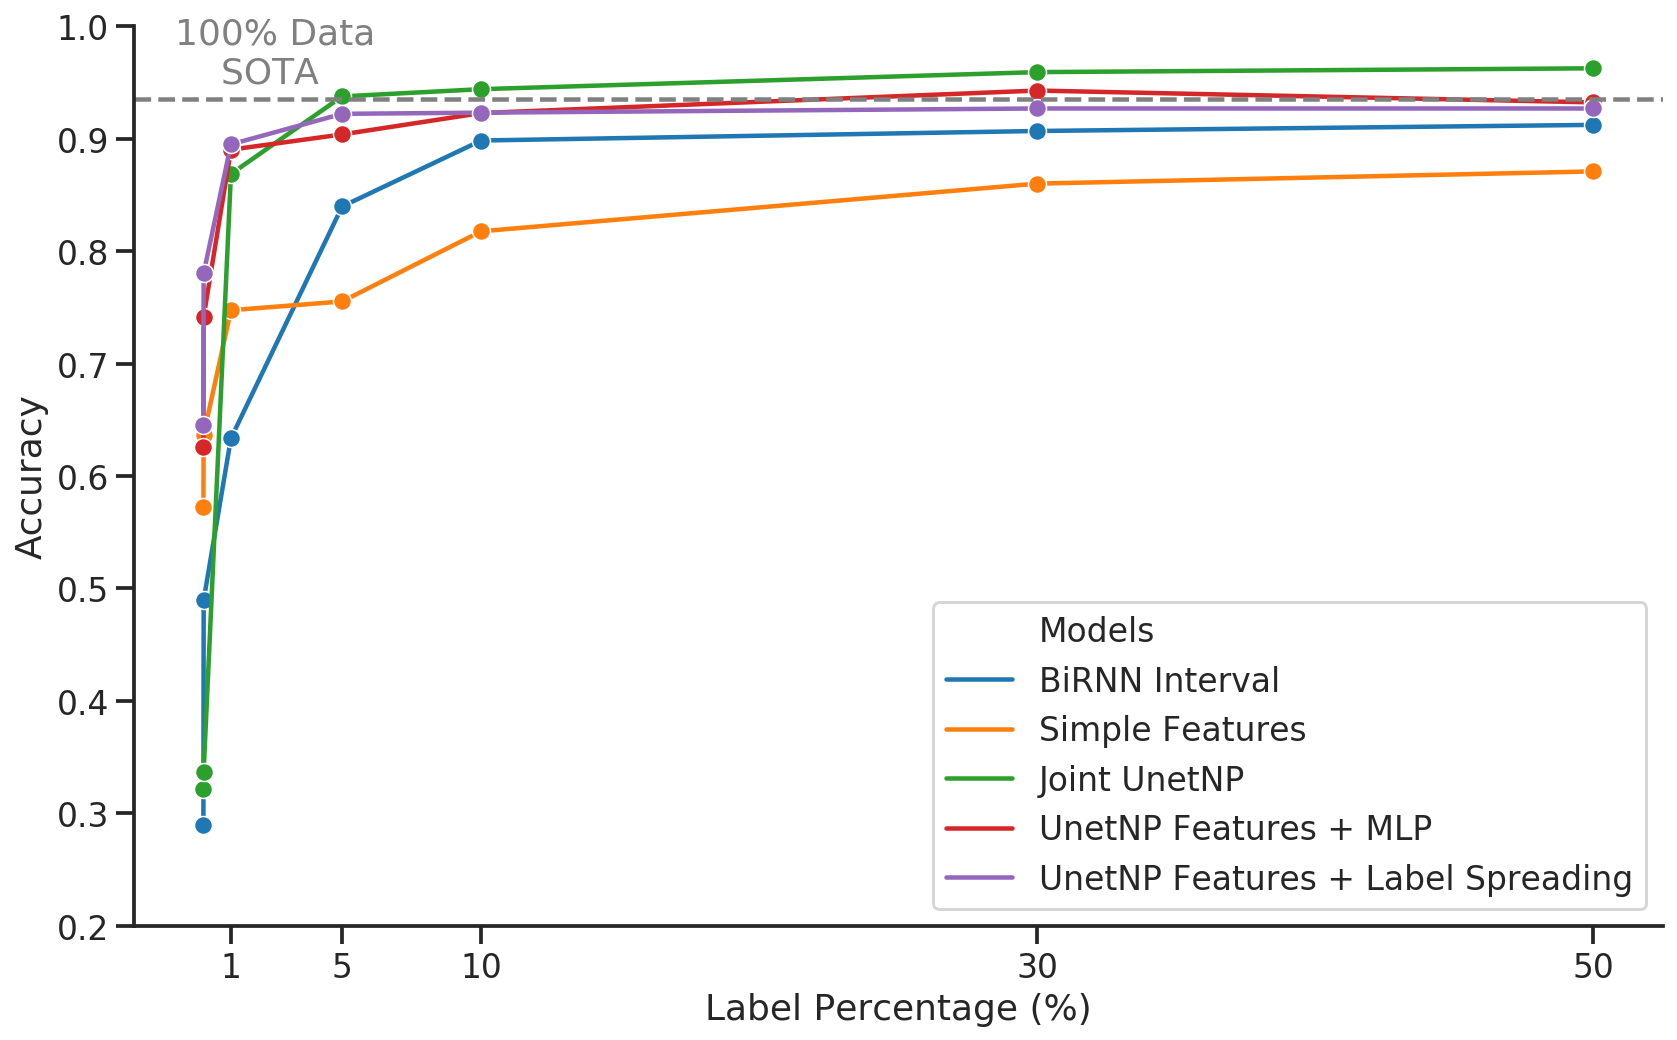

In [114]:
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots(1,1, figsize=(13.7,8.27))
sns.set_style("white")
sns.set_context("talk")
sns.lineplot(data=df, x="Label Percentage (%)", y="Accuracy", hue="Models", marker="o", ax=ax)
ax.set_xticks([l*100 for l in label_percentages[2:]])
ax.set_ylim([0.2,1])
sns.despine()
ax.axhline(0.9357, ls='--', c="gray")
ax.text(-1,0.95, "100% Data\n    SOTA", c="gray")

Text(5, 0.95, 'SOTA')

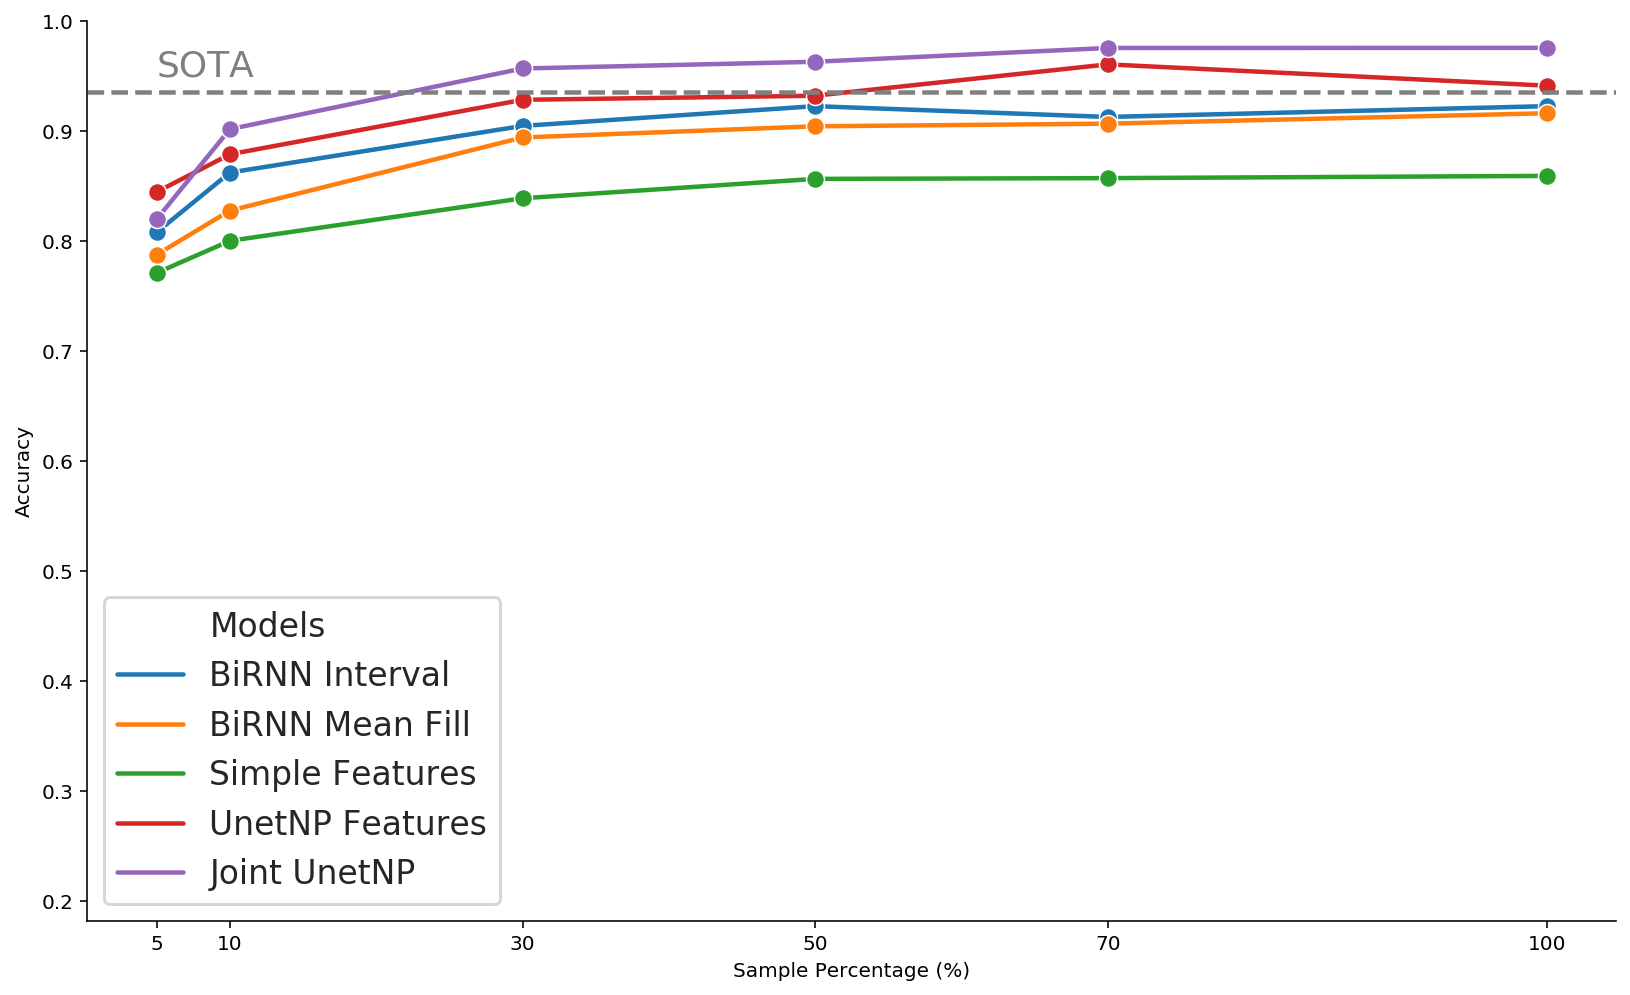

In [46]:
fig, ax = plt.subplots(1,1, figsize=(13.7,8.27))
sns.set_style("white")
sns.set_context("talk")
sns.lineplot(data=df, x="Sample Percentage (%)", y="Accuracy", hue="Models", marker="o", ax=ax)
ax.set_xticks(df["Sample Percentage (%)"].unique())
ax.set_ylim([0.182,1])
sns.despine()
ax.axhline(0.9357, ls='--', c="gray")
ax.text(5,0.95, "SOTA", c="gray")

In [57]:
sns.

accuracy
models                                  data sample          
bi_rnn_delta                            10%          0.862572
                                        100%         0.922973
                                        30%          0.904988
                                        5%           0.808280
                                        50%          0.922973
                                        70%          0.913132
bi_rnn_meanfill                         10%          0.827961
                                        100%         0.916525
                                        30%          0.894469
                                        5%           0.787920
                                        50%          0.904649
                                        70%          0.907024
feature_mlp                             10%          0.800475
                                        100%         0.859518
                                        30%          0.839158
                                        5%           0.771293
                                        50%          0.856804
                                        70%          0.857482
transformer_gnp_large_shared_bottleneck 10%          0.879199
                                        100%         0.941636
                                        30%          0.928741
                                        5%           0.844927
                                        50%          0.932474
                                        70%          0.960977